In [ ]:
import librosa
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def load_audio_dataset(folder_path, target_sr=22050, n_mfcc=13, max_timesteps=125):
    audio_data = []
    labels = []
    emotions = []

    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            label = file.split("_")[0].lower()
            emotions.append(label)
            file_path = os.path.join(folder_path, file)
            signal, sr = librosa.load(file_path, sr=target_sr)
            signal, _ = librosa.effects.trim(signal)

            # 1. MFCC features
            mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
            mfcc = mfcc.T  # Transpose to shape (timesteps, n_mfcc)

            # 2. Chroma features
            chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
            chroma = chroma.T  # Transpose to shape (timesteps, chroma_features)

            # 3. Spectral contrast
            spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr)
            spectral_contrast = spectral_contrast.T  # Transpose to shape (timesteps, spectral_features)

            # 4. RMS Energy
            rms = librosa.feature.rms(y=signal).T  # Shape (timesteps, 1)

            # 5. Zero-Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y=signal).T  # Shape (timesteps, 1)

            # Combine features
            combined_features = np.hstack((mfcc, chroma, spectral_contrast, rms, zcr))

            # Append features and labels
            audio_data.append(combined_features)
            labels.append(label)

    X = pad_sequences(audio_data, maxlen=max_timesteps, padding='post', truncating='post', dtype='float32')

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)
    y = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

    print(f"Shape of X: {X.shape}")  # (num_samples, max_timesteps, feature_dim)
    print(f"Shape of Y: {y.shape}")  # (num_samples, num_classes)
    label_map = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    return X, y, label_map

folder_path = "/content/drive/MyDrive/DL_SpeechEmotion_project/RAVDESS_balanced_complete_dataset"


X, y, label_map = load_audio_dataset(folder_path)

print(f"Label Map: {label_map}")

Shape of X: (6048, 125, 34)
Shape of Y: (6048, 8)
Label Map: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (4233, 125, 34), (4233, 8)
Validation set: (907, 125, 34), (907, 8)
Test set: (908, 125, 34), (908, 8)


# Model 4 : 2 Layer Bi LSTM with no dropout

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model4 = Sequential()

model4.add(Bidirectional(LSTM(units=256,
                             return_sequences=True,
                             kernel_regularizer=l2(0.003)),
                        input_shape=(X_train.shape[1], X_train.shape[2])))
model4.add(Bidirectional(LSTM(units=128,
                             return_sequences=False,
                             kernel_regularizer=l2(0.003))))
model4.add(Dense(units=8, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


print(model4.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 125, 512)            │         595,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,254,408 (4.79 MB)

 Trainable params: 1,254,408 (4.79 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model4.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.2565 - loss: 3.7690 - val_accuracy: 0.3550 - val_loss: 2.0979
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.3836 - loss: 1.9638 - val_accuracy: 0.4002 - val_loss: 1.7925
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4249 - loss: 1.7052 - val_accuracy: 0.4322 - val_loss: 1.6140
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4617 - loss: 1.5780 - val_accuracy: 0.4344 - val_loss: 1.5487
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.4697 - loss: 1.5277 - val_accuracy: 0.4763 - val_loss: 1.4733
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.4996 - loss: 1.4446 - val_accuracy: 0.5072 - val_loss: 1.4254
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5117 - loss: 1.4008 - val_accuracy: 0.5424 - val_loss: 1.3754
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5126 - loss: 1.3850 -

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_accuracy = model4.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = np.argmax(model4.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6855 - loss: 1.1710
Test Loss: 1.2028
Test Accuracy: 0.6707
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       111
           1       0.75      0.66      0.70       107
           2       0.87      0.77      0.82       124
           3       0.56      0.49      0.52       118
           4       0.71      0.62      0.66       125
           5       0.73      0.74      0.73       106
           6       0.43      0.50      0.46       103
           7       0.68      0.85      0.75       114

    accuracy                           0.67       908
   macro avg       0.67      0.67      0.67       908
weighted avg       0.68      0.67      0.67       908



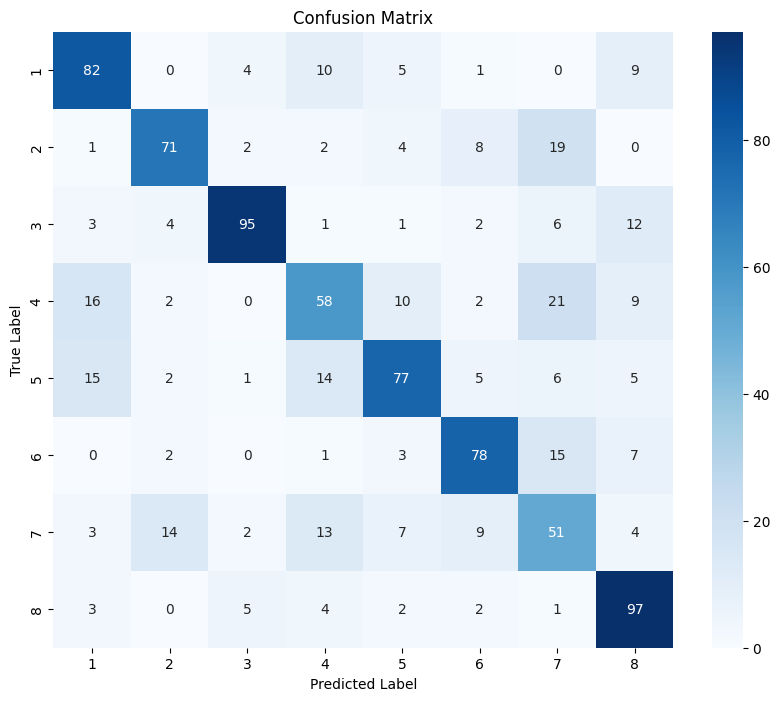

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(1, 9), yticklabels=np.arange(1, 9))
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

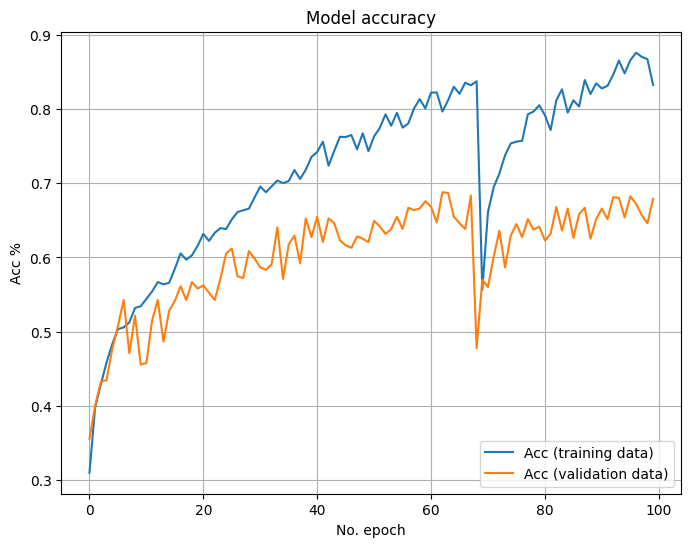

In [ ]:

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acc (training data)')
plt.plot(history.history['val_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
model4.save('/content/drive/MyDrive/DL_SpeechEmotion_project/model_4.keras')

print("Model saved successfully!")


Model saved successfully!
